# Домашнее задание №6. Классификация текста. Анализ тональности текста

In [1]:
# !pip -q install eli5
# !pip -q install spacy
# !python -m spacy download en

## Задание

Взять ноутбук colab_text_classification_part1.ipynb, который разбирали на занятии, и добавить пункты, которые мы пропустили:

1. Посмотрите на токены: если будут мусорные -- добавьте их в стоп-слова и обучите заново.

2. Проверьте, изменилось ли качество при лемматизации/и без неё.

3. Замените все токены, которые принадлежат сущностям, на их тег. Проверьте, изменилось ли качество после этого.

## План решения

[Задание 1. Подбор ключевых слов для увеличения точности](#section_1)

[Задание 2. Регулярное выражение для удаления тегов](#section_2)

[Задание 3. TfidfVectorizer](#section_3)

[Задание 4. TfidfVectorizer с ngram_range](#section_4)

[Задание 5. TfidfVectorizer с analyzer='char')](#section_5)

[Задание 6. Пример разных форм одного слова с разной семантической окраской](#section_6)

[Задание 7. Классификатор на лемматизированных текстах](#section_7)

[Задание 8. Классификатор на тегах (на леммах при отсутствии тегов)](#section_8)

[Задание 9. Классификатор на основах](#section_9)

[Задание 10. Классификатор на леммах с удаленной сущностью ORG](#section_10)

[Задание 11. Конвертация данных](#section_11)

[Задание 12. Подсчет метрики на тесте](#section_12)

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [2]:
import pandas as pd

train_df = pd.read_csv("classif_data/train.tsv", delimiter="\t")
test_df = pd.read_csv("classif_data/test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


In [3]:
train_df.head()

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [4]:
#Начинаем классифицировать
positive_words = ['love', 'great', 'best', 'wonderful']
negative_words = ['worst', 'awful', '1/10', 'crap']

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))

Test accuracy = 66.73%


**Задание 1.** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!) <a id='section_1'></a>

In [5]:
#Начинаем классифицировать
positive_words =  ['great','best', 'wonderful', 'breathtaking', 'first-rate', 'brilliant',
                   'magnetic', 'insightful', 'well-paced', 'must-see', 'charismatic', 
                   'enjoyable', 'hilarious', 'absorbing', 'riveting', 'intriguing', 
                   'powerful', 'fascinating', 'excellent',  'perfect', 'surprised',
                   'delightful', 'incredible', 'fantastic', 'ideal', 'amazing',
                   'refreshing', 'wonderfully', 'funniest', 'surprisingly',
                   'rare', 'superb']
negative_words =  ['worst', 'awful', '1/10', 'crap', 'second-rate',
                    'moronic', 'third-rate',  'juvenile','boring',
                  'worse', 'dull', 'mildly', 'redeeming', 'baldwin', 'weak', 'wooden']

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))

Test accuracy = 72.84%


**Задание 2.** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять <a id='section_2'></a>

In [6]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [7]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [9]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [10]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0f',
 '0ne',
 '0r',
 '0s',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '1

Попробуем кого-нибудь таки сконвертировать

In [11]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [13]:
model.fit(train_df['review'], train_df['is_positive'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def eval_model(model, test_df_X, test_df_Y):
    preds = model.predict(test_df_X)
    print('Test precision = {:.2%}'.format(precision_score(test_df_Y, preds)))
    print('Test recall = {:.2%}'.format(recall_score(test_df_Y, preds)))
    print('Test f1 = {:.2%}'.format(f1_score(test_df_Y, preds)))
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df_Y, preds)))
    
eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 87.03%
Test recall = 85.81%
Test f1 = 86.42%
Test accuracy = 86.51%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [16]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Weight?,Feature
+1.863,refreshing
+1.771,wonderfully
+1.701,funniest
+1.656,surprisingly
+1.635,rare
+1.441,superb
+1.385,excellent
+1.373,incredible
+1.339,perfect
+1.307,delightful


Посмотрим на конкретные примеры его работы:

In [17]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [18]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [19]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание 3.** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`. <a id='section_3'></a>

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 88.37%
Test recall = 88.17%
Test f1 = 88.27%
Test accuracy = 88.28%


In [21]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+7.553,great
+6.153,excellent
+5.121,best
+4.814,perfect
+4.653,wonderful
+4.132,amazing
+4.000,well
+3.837,loved
+3.772,favorite
+3.769,fun


In [22]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [23]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


TfidfVectorizer имеет лучшие показатели метрики. Значитель лучше распознает negative класс.

### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание 4.** Попробуйте увеличенный range и поинтерпретируйте полученный результат. <a id='section_4'></a>

In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 88.01%
Test recall = 89.47%
Test f1 = 88.74%
Test accuracy = 88.64%


до использования n-грамм:
Test precision = 88.37%
Test recall = 88.17%
Test f1 = 88.27%
Test accuracy = 88.28%

Вывод: метрика f1 выросла, следовательно, целесообразно использовать ngram_range=(1, 2)

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 87.01%
Test recall = 88.76%
Test f1 = 87.88%
Test accuracy = 87.76%


до использования n-грамм:
Test precision = 88.37%
Test recall = 88.17%
Test f1 = 88.27%
Test accuracy = 88.28%

Вывод: метрика f1 выросла, но упала по сравнению с ngram_range=(1, 2). Значит, использовать ngram_range=(1, 3) не целесообразно

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(2, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 85.62%
Test recall = 87.50%
Test f1 = 86.55%
Test accuracy = 86.40%


до использования n-грамм:
Test precision = 88.37%
Test recall = 88.17%
Test f1 = 88.27%
Test accuracy = 88.28%

Вывод: метрика f1 упала, значит, использовать ngram_range=(2, 3) не целесообразно

In [27]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 85.39%
Test recall = 84.45%
Test f1 = 84.92%
Test accuracy = 85.00%


до использования n-грамм:
Test precision = 88.37%
Test recall = 88.17%
Test f1 = 88.27%
Test accuracy = 88.28%

Вывод: метрика f1 упала, значит, использовать ngram_range=(2, 6) не целесообразно

### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание 5.** Запилите классификатор на n-граммах символов и визуализируйте его.<a id='section_5'></a>

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), 
                             max_features=20000, #в словарь попадут 20000 слов
                             analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test precision = 87.49%
Test recall = 88.34%
Test f1 = 87.91%
Test accuracy = 87.86%


до использования n-грамм символов: Test precision = 88.37% Test recall = 88.17% Test f1 = 88.27% Test accuracy = 88.28%

Вывод: метрика f1 упала, значит, использовать analyzer='char' с ngram_range=(2, 6) не целесообразно

In [29]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание 6.** Найти формы слова с разной семантической окраской. <a id='section_6'></a>

Например, movie (positive) и moving (negative).

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [30]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm") #загружаем тренированный пайплайн

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])] 

In [31]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Dreamgirls dreamgirl O 
, , O 
despite despite O 
its its O 
fistful fistful O 
of of O 
Tony Tony B PERSON
wins win O 
in in O 
an an B DATE
incredibly incredibly I DATE
weak weak I DATE
year year I DATE
on on O 
Broadway Broadway B FAC
, , O 
has have O 
never never O 
been be O 
what what O 
one one O 
would would O 
call call O 
a a O 
jewel jewel O 
in in O 
the the O 
crown crown O 
of of O 
stage stage O 
musicals musical O 
. . O 
However however O 
, , O 
that that O 
is be O 
not not O 
to to O 
say say O 
that that O 
in in O 
the the O 
right right O 
cinematic cinematic O 
hands hand O 
it it O 
could could O 
not not O 
be be O 
fleshed flesh O 
out out O 
and and O 
polished polish O 
into into O 
something something O 
worthwhile worthwhile O 
on on O 
- - O 
screen screen O 
. . O 
Unfortunately unfortunately O 
, , O 
what what O 
transfers transfer O 
to to O 
the the O 
screen screen O 
is be O 
basically basically O 
a a O 
slavishly slavishly O 
faithful faithful 

**Задание 7.** Сделайте классификатор на лемматизированных текстах. <a id='section_7'></a>

In [32]:
#тренировочный датасет
train_df.head()

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...


In [33]:
#каждый review разбиваем на лемматизированные токены
def lemmatize_review(text):
    doc = nlp(text)
    tokens_lemm_list = [token.lemma_ for token in doc]
    lemmatize_review = ' '.join(tokens_lemm_list)
    return lemmatize_review

In [34]:
#применим преобразования к тренировочному датасету
train_df['review_lemmatized'] = train_df['review'].apply(lemmatize_review)
train_df.head()

,is_positive,review,review_lemmatized
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirl , despite its fistful of Tony win in..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...


In [35]:
#тестовый датасет
test_df.head()

,is_positive,review
0,0,A formulaic story with all the tired cliches. ...
1,1,This is both an entertaining and a touching ve...
2,0,Corey Haim is never going to be known as one o...
3,1,If you believe that any given war movie can ma...
4,1,Carla Gugino literally melts the screen in thi...


In [36]:
#применим преобразования к тестовому датасету
test_df['review_lemmatized'] = test_df['review'].apply(lemmatize_review)
test_df.head()

,is_positive,review,review_lemmatized
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...
1,1,This is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...
2,0,Corey Haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...
3,1,If you believe that any given war movie can ma...,if you believe that any give war movie can mak...
4,1,Carla Gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...


In [37]:
#обучим классификатор на лемматизированных текстах
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_lemmatized'], train_df['is_positive'])

eval_model(model, test_df['review_lemmatized'], test_df['is_positive'])

Test precision = 88.11%
Test recall = 89.58%
Test f1 = 88.84%
Test accuracy = 88.74%


До лемматизации:
Test precision = 88.01%
Test recall = 89.47%
Test f1 = 88.74%
Test accuracy = 88.64%

Вывод: метрика f1 выросла. Следовательно, целесообразно использование лемматизации.

Теперь уберем из токенов стоп-слова и пунктуацию. Обучим классификатор заново.

In [38]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [39]:
from string import punctuation
#знаки пунктуации
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
noise = stopwords.words("english") + list(punctuation)
print(noise)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [41]:
#каждый review разбиваем на лемматизированные токены и убираем мусор
def lemmatize_review_clear(text):
    doc = nlp(text)
    tokens_lemm_list = [token.lemma_ for token in doc]
    tokens_lemm_list_clear = [token for token in tokens_lemm_list if not token in noise]
    lemmatize_review_clear = ' '.join(tokens_lemm_list_clear)
    return lemmatize_review_clear

In [42]:
#применим преобразования к тренировочному датасету
train_df['review_lemmatized_clear'] = train_df['review'].apply(lemmatize_review_clear)
train_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirl , despite its fistful of Tony win in...",dreamgirl despite fistful Tony win incredibly ...
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,show come interesting location fast travel cha...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,I simply love movie I also love Ramones I sort...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead want call ... I would almost r...
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,time favorite movie I see many movie one beat ...


In [43]:
#применим преобразования к тестовому датасету
test_df['review_lemmatized_clear'] = test_df['review'].apply(lemmatize_review_clear)
test_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...
1,1,This is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...,entertaining touching version classic tale als...
2,0,Corey Haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...,Corey Haim never go know one great actor time ...
3,1,If you believe that any given war movie can ma...,if you believe that any give war movie can mak...,believe give war movie make really feel war ne...
4,1,Carla Gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...,Carla Gugino literally melt screen crime caper...


In [44]:
#обучим классификатор на лемматизированных и вычищенных текстах
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_lemmatized_clear'], train_df['is_positive'])

eval_model(model, test_df['review_lemmatized_clear'], test_df['is_positive'])

Test precision = 87.09%
Test recall = 88.50%
Test f1 = 87.79%
Test accuracy = 87.69%


До лемматизации:
Test precision = 88.01%
Test recall = 89.47%
Test f1 = 88.74%
Test accuracy = 88.64%

После лемматизации (со стоп-словами):
Test precision = 88.11%
Test recall = 89.58%
Test f1 = 88.84%
Test accuracy = 88.74%

Вывод: метрика f1 упала. Следовательно, лучше проводить лемматизацию и не удалять стоп-слова.

**Вывод:** при обучение на леммах токенов качество модели улучшается (лемматизация без удаления стоп-слов)

**Задание 8.** Обучим вместо лемм их тегги (в случае их наличия).  <a id='section_8'></a>

In [45]:
#каждый review разбиваем на лемматизированные токены. При этом токены, у которых есть тег, заменяем тегом!
def lemmatize_review_entity(text):
    doc = nlp(text)
    tokens_lemm_list = [token.lemma_ if token.ent_type_ == '' else token.ent_type_ for token in doc]
    lemmatize_review_entity = ' '.join(tokens_lemm_list)
    return lemmatize_review_entity

In [46]:
#применим преобразования к тренировочному датасету
train_df['review_lemmatized_entity'] = train_df['review'].apply(lemmatize_review_entity)
train_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear,review_lemmatized_entity
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirl , despite its fistful of Tony win in...",dreamgirl despite fistful Tony win incredibly ...,"dreamgirl , despite its fistful of PERSON win ..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,show come interesting location fast travel cha...,this show come up with interesting location as...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,I simply love movie I also love Ramones I sort...,I simply love this movie . I also love the Ram...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead want call ... I would almost r...,spoiler ahead if you want to call they that .....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,time favorite movie I see many movie one beat ...,my all - time favorite movie ! I have see many...


In [47]:
#применим преобразования к тестовому датасету
test_df['review_lemmatized_enity'] = test_df['review'].apply(lemmatize_review_entity)
test_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear,review_lemmatized_enity
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...,a formulaic story with all the tired cliche . ...
1,1,This is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...,entertaining touching version classic tale als...,this be both an entertaining and a touching ve...
2,0,Corey Haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...,Corey Haim never go know one great actor time ...,PERSON PERSON be never go to be know as one of...
3,1,If you believe that any given war movie can ma...,if you believe that any give war movie can mak...,believe give war movie make really feel war ne...,if you believe that any give war movie can mak...
4,1,Carla Gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...,Carla Gugino literally melt screen crime caper...,PERSON PERSON literally melt the screen in thi...


In [48]:
#обучим классификатор на лемматизированных текстах, в которых токены заменены тегами
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_lemmatized_entity'], train_df['is_positive'])

eval_model(model, test_df['review_lemmatized_enity'], test_df['is_positive'])

Test precision = 87.75%
Test recall = 89.89%
Test f1 = 88.81%
Test accuracy = 88.67%


Результаты после лемматизации: Test precision = 88.11%
Test recall = 89.58%
Test f1 = 88.84%
Test accuracy = 88.74%

Вывод: метрика f1 стала меньше. Следовательно, использование тегов вместо лемм не способствует повышению качества модели.

Теперь уберем из токенов стоп-слова и пунктуацию. Обучим классификатор заново.

In [49]:
#каждый review разбиваем на лемматизированные токены. При этом токены, у которых есть тег, заменяем тегом! Убираем мусор
def lemmatize_review_entity_clear(text):
    doc = nlp(text)
    tokens_lemm_list = [token.lemma_ if token.ent_type_ == '' else token.ent_type_ for token in doc]
    tokens_lemm_list_clear = [token for token in tokens_lemm_list if not token in noise]
    lemmatize_review_entity_clear = ' '.join(tokens_lemm_list_clear)
    return lemmatize_review_entity_clear 

In [50]:
#применим преобразования к тренировочному датасету
train_df['review_lemmatized_entity_clear'] = train_df['review'].apply(lemmatize_review_entity_clear)
train_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear,review_lemmatized_entity,review_lemmatized_entity_clear
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirl , despite its fistful of Tony win in...",dreamgirl despite fistful Tony win incredibly ...,"dreamgirl , despite its fistful of PERSON win ...",dreamgirl despite fistful PERSON win DATE DATE...
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,show come interesting location fast travel cha...,this show come up with interesting location as...,show come interesting location fast travel cha...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,I simply love movie I also love Ramones I sort...,I simply love this movie . I also love the Ram...,I simply love movie I also love Ramones I sort...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead want call ... I would almost r...,spoiler ahead if you want to call they that .....,spoiler ahead want call ... I would almost r...
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,time favorite movie I see many movie one beat ...,my all - time favorite movie ! I have see many...,time favorite movie I see many movie one beat ...


In [51]:
#применим преобразования к тестовому датасету
test_df['review_lemmatized_enity_Clear'] = test_df['review'].apply(lemmatize_review_entity_clear)
test_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear,review_lemmatized_enity,review_lemmatized_enity_Clear
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...
1,1,This is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...,entertaining touching version classic tale als...,this be both an entertaining and a touching ve...,entertaining touching version classic tale als...
2,0,Corey Haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...,Corey Haim never go know one great actor time ...,PERSON PERSON be never go to be know as one of...,PERSON PERSON never go know one great actor ti...
3,1,If you believe that any given war movie can ma...,if you believe that any give war movie can mak...,believe give war movie make really feel war ne...,if you believe that any give war movie can mak...,believe give war movie make really feel war ne...
4,1,Carla Gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...,Carla Gugino literally melt screen crime caper...,PERSON PERSON literally melt the screen in thi...,PERSON PERSON literally melt screen crime cape...


In [52]:
#обучим классификатор на лемматизированных текстах, в которых токены заменены тегами и убран мусор
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_lemmatized_entity_clear'], train_df['is_positive'])

eval_model(model, test_df['review_lemmatized_enity_Clear'], test_df['is_positive'])

Test precision = 86.02%
Test recall = 88.88%
Test f1 = 87.43%
Test accuracy = 87.22%


Результаты после лемматизации: Test precision = 88.11%
Test recall = 89.58%
Test f1 = 88.84%
Test accuracy = 88.74%

Вывод: метрика f1 стала меньше. Следовательно, использование тегов вместо лемм не способствует повышению качества модели.

**Вывод:** использование тегов вместо лемм на классификаторе снижают качество модели.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [53]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание 9.** Попробуйте вместо лемм классифицировать основы.  <a id='section_9'></a>

In [54]:
def stem_review(text):
    list_word = text.split()
    list_stem = [stemmer.stem(word) for word in list_word]
    stem_text = ' '.join(list_stem)
    return stem_text

In [55]:
#применим преобразования к тренировочному датасету
train_df['stem_review'] = train_df['review'].apply(stem_review)
train_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear,review_lemmatized_entity,review_lemmatized_entity_clear,stem_review
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirl , despite its fistful of Tony win in...",dreamgirl despite fistful Tony win incredibly ...,"dreamgirl , despite its fistful of PERSON win ...",dreamgirl despite fistful PERSON win DATE DATE...,"dreamgirls, despit it fist of toni win in an i..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,show come interesting location fast travel cha...,this show come up with interesting location as...,show come interesting location fast travel cha...,thi show come up with interest locat as fast a...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,I simply love movie I also love Ramones I sort...,I simply love this movie . I also love the Ram...,I simply love movie I also love Ramones I sort...,I simpli love thi movie. I also love the ramon...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead want call ... I would almost r...,spoiler ahead if you want to call they that .....,spoiler ahead want call ... I would almost r...,spoiler ahead if you want to call them that......
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,time favorite movie I see many movie one beat ...,my all - time favorite movie ! I have see many...,time favorite movie I see many movie one beat ...,My all-tim favorit movie! I have seen mani mov...


In [56]:
#применим преобразования к тестовому датасету
test_df['stem_review'] = test_df['review'].apply(stem_review)
test_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear,review_lemmatized_enity,review_lemmatized_enity_Clear,stem_review
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...,A formula stori with all the tire cliches. I w...
1,1,This is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...,entertaining touching version classic tale als...,this be both an entertaining and a touching ve...,entertaining touching version classic tale als...,thi is both an entertain and a touch version o...
2,0,Corey Haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...,Corey Haim never go know one great actor time ...,PERSON PERSON be never go to be know as one of...,PERSON PERSON never go know one great actor ti...,corey haim is never go to be known as one of t...
3,1,If you believe that any given war movie can ma...,if you believe that any give war movie can mak...,believe give war movie make really feel war ne...,if you believe that any give war movie can mak...,believe give war movie make really feel war ne...,If you believ that ani given war movi can make...
4,1,Carla Gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...,Carla Gugino literally melt screen crime caper...,PERSON PERSON literally melt the screen in thi...,PERSON PERSON literally melt screen crime cape...,carla gugino liter melt the screen in thi crim...


In [57]:
#обучим классификатор на основах
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['stem_review'], train_df['is_positive'])

eval_model(model, test_df['stem_review'], test_df['is_positive'])

Test precision = 87.70%
Test recall = 89.06%
Test f1 = 88.37%
Test accuracy = 88.28%


До лемматизации:
Test precision = 88.01%
Test recall = 89.47%
Test f1 = 88.74%
Test accuracy = 88.64%

После лемматизации (со стоп-словами):
Test precision = 88.11%
Test recall = 89.58%
Test f1 = 88.84%
Test accuracy = 88.74%

Вывод: f1 даже ниже, чем до обучения на основах.

Теперь уберем из основ стоп-слова и пунктуацию. Обучим классификатор заново.

In [58]:
def stem_review_clear(text):
    list_word = text.split()
    list_stem = [stemmer.stem(word) for word in list_word]
    list_stem_clear = [stem for stem in list_stem if not stem in noise]
    stem_text_clear = ' '.join(list_stem_clear)
    return stem_text_clear

In [59]:
#применим преобразования к тренировочному датасету
train_df['stem_review_clear'] = train_df['review'].apply(stem_review_clear)
train_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear,review_lemmatized_entity,review_lemmatized_entity_clear,stem_review,stem_review_clear
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirl , despite its fistful of Tony win in...",dreamgirl despite fistful Tony win incredibly ...,"dreamgirl , despite its fistful of PERSON win ...",dreamgirl despite fistful PERSON win DATE DATE...,"dreamgirls, despit it fist of toni win in an i...","dreamgirls, despit fist toni win incred weak y..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,show come interesting location fast travel cha...,this show come up with interesting location as...,show come interesting location fast travel cha...,thi show come up with interest locat as fast a...,thi show come interest locat fast travel chann...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,I simply love movie I also love Ramones I sort...,I simply love this movie . I also love the Ram...,I simply love movie I also love Ramones I sort...,I simpli love thi movie. I also love the ramon...,"I simpli love thi movie. I also love ramones, ..."
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead want call ... I would almost r...,spoiler ahead if you want to call they that .....,spoiler ahead want call ... I would almost r...,spoiler ahead if you want to call them that......,spoiler ahead want call that... I would almost...
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,time favorite movie I see many movie one beat ...,my all - time favorite movie ! I have see many...,time favorite movie I see many movie one beat ...,My all-tim favorit movie! I have seen mani mov...,"My all-tim favorit movie! I seen mani movies, ..."


In [60]:
#применим преобразования к тестовому датасету
test_df['stem_review_clear'] = test_df['review'].apply(stem_review_clear)
test_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear,review_lemmatized_enity,review_lemmatized_enity_Clear,stem_review,stem_review_clear
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...,A formula stori with all the tire cliches. I w...,A formula stori tire cliches. I wa shock horri...
1,1,This is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...,entertaining touching version classic tale als...,this be both an entertaining and a touching ve...,entertaining touching version classic tale als...,thi is both an entertain and a touch version o...,"thi entertain touch version classic tale, also..."
2,0,Corey Haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...,Corey Haim never go know one great actor time ...,PERSON PERSON be never go to be know as one of...,PERSON PERSON never go know one great actor ti...,corey haim is never go to be known as one of t...,corey haim never go known one great actor hi t...
3,1,If you believe that any given war movie can ma...,if you believe that any give war movie can mak...,believe give war movie make really feel war ne...,if you believe that any give war movie can mak...,believe give war movie make really feel war ne...,If you believ that ani given war movi can make...,If believ ani given war movi make realli feel ...
4,1,Carla Gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...,Carla Gugino literally melt screen crime caper...,PERSON PERSON literally melt the screen in thi...,PERSON PERSON literally melt screen crime cape...,carla gugino liter melt the screen in thi crim...,carla gugino liter melt screen thi crime caper...


In [61]:
#обучим классификатор на основах
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['stem_review_clear'], train_df['is_positive'])

eval_model(model, test_df['stem_review_clear'], test_df['is_positive'])

Test precision = 87.39%
Test recall = 88.48%
Test f1 = 87.93%
Test accuracy = 87.86%


До лемматизации:
Test precision = 88.01%
Test recall = 89.47%
Test f1 = 88.74%
Test accuracy = 88.64%

После лемматизации (со стоп-словами):
Test precision = 88.11%
Test recall = 89.58%
Test f1 = 88.84%
Test accuracy = 88.74%

Вывод: f1 хуже, чем до обучения на основах.

**Вывод:** при обучение на основах токенов качество модели падает

In [62]:
# train_df.to_csv('train_df.csv') 
# test_df.to_csv('test_df.csv') 

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [63]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание 10.** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор. <a id='section_9'></a>

Удалим сущности ORG

In [64]:
def del_entity_ORG(text):
    doc = nlp(text)
    tokens_lemm_list = [token.lemma_ for token in doc if token.ent_type_ !='ORG']
    del_entity_ORG  = ' '.join(tokens_lemm_list)
    return del_entity_ORG

In [65]:
#применим преобразования к тренировочному датасету
train_df['lemm_del_entity_ORG'] = train_df['review'].apply(del_entity_ORG)
train_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear,review_lemmatized_entity,review_lemmatized_entity_clear,stem_review,stem_review_clear,lemm_del_entity_ORG
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirl , despite its fistful of Tony win in...",dreamgirl despite fistful Tony win incredibly ...,"dreamgirl , despite its fistful of PERSON win ...",dreamgirl despite fistful PERSON win DATE DATE...,"dreamgirls, despit it fist of toni win in an i...","dreamgirls, despit fist toni win incred weak y...","dreamgirl , despite its fistful of Tony win in..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,show come interesting location fast travel cha...,this show come up with interesting location as...,show come interesting location fast travel cha...,thi show come up with interest locat as fast a...,thi show come interest locat fast travel chann...,this show come up with interesting location as...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,I simply love movie I also love Ramones I sort...,I simply love this movie . I also love the Ram...,I simply love movie I also love Ramones I sort...,I simpli love thi movie. I also love the ramon...,"I simpli love thi movie. I also love ramones, ...",I simply love this movie . I also love the Ram...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead want call ... I would almost r...,spoiler ahead if you want to call they that .....,spoiler ahead want call ... I would almost r...,spoiler ahead if you want to call them that......,spoiler ahead want call that... I would almost...,spoiler ahead if you want to call they that .....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,time favorite movie I see many movie one beat ...,my all - time favorite movie ! I have see many...,time favorite movie I see many movie one beat ...,My all-tim favorit movie! I have seen mani mov...,"My all-tim favorit movie! I seen mani movies, ...",my all - time favorite movie ! I have see many...


In [66]:
#применим преобразования к тестовому датасету
test_df['lemm_del_entity_ORG'] = test_df['review'].apply(del_entity_ORG)
test_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clear,review_lemmatized_enity,review_lemmatized_enity_Clear,stem_review,stem_review_clear,lemm_del_entity_ORG
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...,A formula stori with all the tire cliches. I w...,A formula stori tire cliches. I wa shock horri...,a formulaic story with all the tired cliche . ...
1,1,This is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...,entertaining touching version classic tale als...,this be both an entertaining and a touching ve...,entertaining touching version classic tale als...,thi is both an entertain and a touch version o...,"thi entertain touch version classic tale, also...",this be both an entertaining and a touching ve...
2,0,Corey Haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...,Corey Haim never go know one great actor time ...,PERSON PERSON be never go to be know as one of...,PERSON PERSON never go know one great actor ti...,corey haim is never go to be known as one of t...,corey haim never go known one great actor hi t...,Corey Haim be never go to be know as one of th...
3,1,If you believe that any given war movie can ma...,if you believe that any give war movie can mak...,believe give war movie make really feel war ne...,if you believe that any give war movie can mak...,believe give war movie make really feel war ne...,If you believ that ani given war movi can make...,If believ ani given war movi make realli feel ...,if you believe that any give war movie can mak...
4,1,Carla Gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...,Carla Gugino literally melt screen crime caper...,PERSON PERSON literally melt the screen in thi...,PERSON PERSON literally melt screen crime cape...,carla gugino liter melt the screen in thi crim...,carla gugino liter melt screen thi crime caper...,Carla Gugino literally melt the screen in this...


In [67]:
#обучим классификатор на основах
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['lemm_del_entity_ORG'], train_df['is_positive'])

eval_model(model, test_df['lemm_del_entity_ORG'], test_df['is_positive'])

Test precision = 88.16%
Test recall = 89.62%
Test f1 = 88.88%
Test accuracy = 88.79%


До лемматизации:
Test precision = 88.01%
Test recall = 89.47%
Test f1 = 88.74%
Test accuracy = 88.64%

После лемматизации (со стоп-словами):
Test precision = 88.11%
Test recall = 89.58%
Test f1 = 88.84%
Test accuracy = 88.74%

Вывод: метрика f1 стала лучше. Следовательно, удаление лемм некоторых сущностей полезно для повышения качества модели.

**Вывод:** классификатор на леммах с удалением сущностей (например, ORG) способствует улучшению качества модели.

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [68]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<BarContainer object of 231 artists>

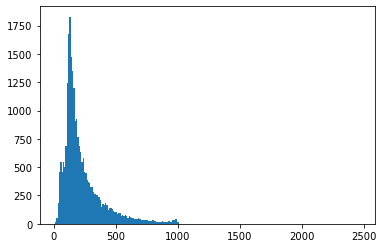

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [70]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26783


**Задание 11.** Сконвертируйте данные <a id='section_11'></a>

In [71]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

<ipython-input-71-27b1b5540537>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
<ipython-input-71-27b1b5540537>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [72]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [73]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [74]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          1714112   
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,714,883
Trainable params: 1,714,883
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 19s 95ms/step - loss: 0.6635 - accuracy: 0.6165 - val_loss: 0.3948 - val_accuracy: 0.8444
Epoch 2/10
196/196 [==============================] - 18s 93ms/step - loss: 0.3183 - accuracy: 0.8770 - val_loss: 0.2937 - val_accuracy: 0.8766
Epoch 3/10
196/196 [==============================] - 18s 94ms/step - loss: 0.1713 - accuracy: 0.9415 - val_loss: 0.2908 - val_accuracy: 0.8799
Epoch 4/10
196/196 [==============================] - 18s 94ms/step - loss: 0.0989 - accuracy: 0.9726 - val_loss: 0.3171 - val_accuracy: 0.8763
Epoch 5/10
196/196 [==============================] - 18s 94ms/step - loss: 0.0486 - accuracy: 0.9910 - val_loss: 0.3615 - val_accuracy: 0.8738
Epoch 6/10
196/196 [==============================] - 18s 94ms/step - loss: 0.0210 - accuracy: 0.9978 - val_loss: 0.3962 - val_accuracy: 0.8714
Epoch 7/10
196/196 [==============================] - 18s 94ms/step - loss: 0.0104 - accuracy: 0.9993 - val_loss: 0.4254 - val_accuracy:

**Задание 12.** Подсчитайте качество модели на тесте <a id='section_12'></a>

In [76]:
#получим предсказания модели
preds = model.predict(X_test)
preds

array([[0.00181335],
       [0.9999993 ],
       [0.16950956],
       ...,
       [0.9961388 ],
       [0.9999989 ],
       [0.37605378]], dtype=float32)

In [77]:
#переводим вероятности в классы (в качестве порога 0.5)
threshold = 0.5
preds[preds >= threshold] = 1
preds[preds < threshold] = 0
preds.T[0]

array([0., 1., 0., ..., 1., 1., 0.], dtype=float32)

In [78]:
#истинные значения классов
test_df.is_positive.to_numpy()

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [79]:
#считаем метрику accuracy на test
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(preds, test_df.is_positive.values)
accuracy.result().numpy()

0.86844